# Classificador de Artistas

O objetivo desse desafio é classificar com base no trecho de uma musica, qual artista é o cantor.



In [150]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import entropy
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [93]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/andresacilotti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Extração de dados

In [6]:
data = pd.read_excel("Data/dataset.xls", sheet_name='NLP')

In [7]:
data

,letra,artista
0,Jay-z Uh-uh-uh You ready b? Let's go get 'em. ...,Beyoncé
1,Your challengers are a young group from Housto...,Beyoncé
2,"Dum-da-de-da Do, do, do, do, do, do (Coming do...",Beyoncé
3,If I ain't got nothing I got you If I ain't go...,Beyoncé
4,Six inch heels She walked in the club like nob...,Beyoncé
...,...,...
513,Yeah yeah Yeah yeah I ain't trying to think a...,Rihanna
514,You the one that I dream about all day You the...,Rihanna
515,"No, no, no You don't love me and I know now No...",Rihanna
516,"You should be mine Oh baby, oh baby, oh baby, ...",Rihanna


## Analise Exploratoria

### Distribuiçao das classes

Um ponto inicial interessante é analisar a distribuição das classes e verificar se há dados desbalanceados ou não, para que assim possa inferido a necessidade de tratamentos especiais como data agumentation ou não.

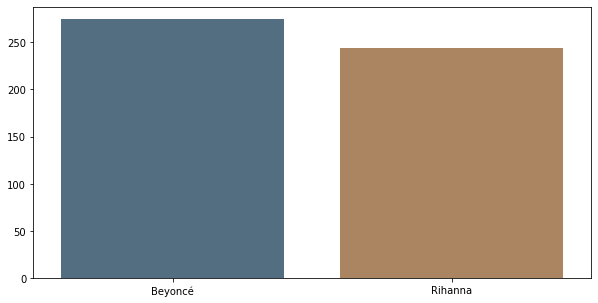

In [57]:
y = list(data['artista'].value_counts())
x = list(np.unique(data['artista']))

plt.figure(figsize=(10, 5))
sns.barplot(x, y, saturation=0.3)

Temos uma informação super importante, trata-se de uma classificação binaria, pois há somente duas classes.

Além disso, os dados não estão tão desbalanceados, podemos checar a entropia para ter certeza. Lembrando que, pela entropia de Shannon:

0 - Completamente desbalanceado;

1 - Completamente Balanceado

In [55]:
print("Entropia:", entropy([new_val/sum(y) for new_val in y], base=2))

Entropia: 0.9975791349905527


### Dados Faltantes

Há alguns tratamentos especiais para tal caso e não podemos ignorar dados ausentes.

Dados Faltantes: ['Artista', 'Letra'] -> [0, 0]


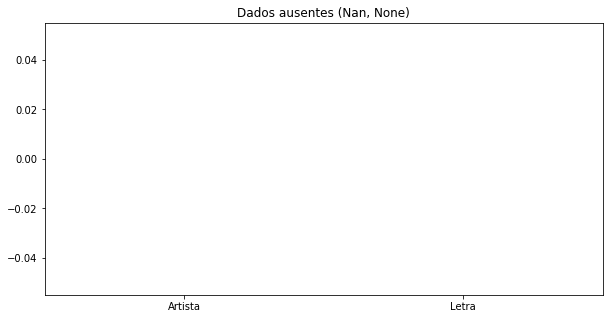

In [65]:
x = ["Artista", "Letra"]
y = [data['artista'].isna().sum(), data['letra'].isna().sum()]


plt.figure(figsize=(10, 5))
plt.title("Dados ausentes (Nan, None)")
sns.barplot(x, y, saturation=0.3)

print("Dados Faltantes: {} -> {}".format(x, y))

No entanto, não há dados ausentes nessa base de dados

### Quantidade de palavras em cada letra

Alguns algoritmos como o BERT, possuem uma limitação de tokens (Palavras) a serem usadas no embedding, portanto, devemos checar se a quantidade de palavras e inferir uma media.

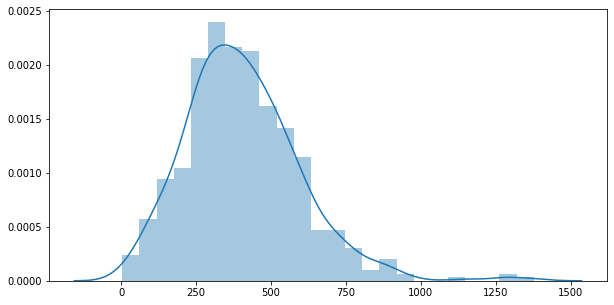

In [89]:
words = data['letra'].str.split(" ").replace(" ", "")
song_size = [len(_words) for _words in words]

plt.figure(figsize=(10, 5))
sns.distplot(song_size)

In [90]:
print("Média: ", sum(song_size)/len(song_size))
print("Mediana: ", np.median(song_size))

Média:  405.8050193050193
Mediana:  386.0


Temos o valor médio da quantidade palavras, em alguns casos ultrapassa o limite de tokens do BERT, no entanto, ainda teremos que decidir qual modelos usar mais a frente

### Presença de stopswords

Stopwords são palavras que em alguns contextos podem ser irrelevantes, por isso, precisamos analisar a presença das mesmas para que possamos julgar se há necessidade um processamento futuro

In [109]:
stop_words = set(stopwords.words('english'))
stop_words


stop_words_in_songs = {}

for rows in words:
    for _word in rows:
        if _word == stop_words:
            try:
                stop_words_in_songs[_word] += 1
            except:
                stop_words_in_songs[_word] = 1

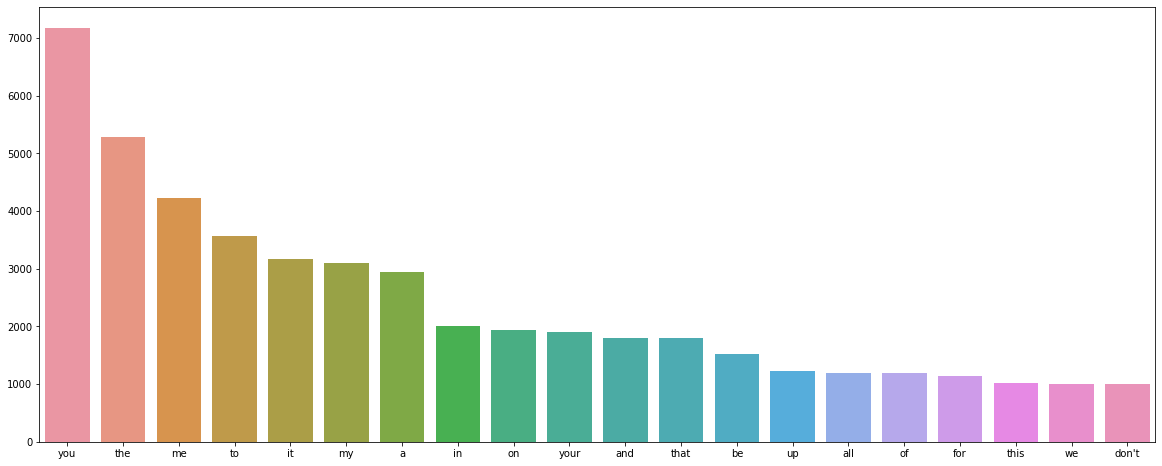

In [137]:
stop_words_in_songs = dict(sorted(stop_words_in_songs.items(), key=lambda item: item[1], reverse=True))

y = list(stop_words_in_songs.values())[:20]
x = list(stop_words_in_songs.keys())[:20]

plt.figure(figsize=(20, 8))
sns.barplot(x=x, y=y)

Observa-se que há uma grande prevalencia de stopwords, palavras como you, the, me, to, it provavelmente não nos ajudarão a saber quem é o cantor, no entanto, faremos testes para confirmar nossa hipotese futuramente

## Processamento dos dados

No nosso processo de treinamento de dados, vamos testar os seguintes processamentos

* Dados cru
* Dados sem stopwords
* Augmentation para padronização das classes (50%, 50%)

Para os modelos mais classicos será utilizado o TF-IDF para estruturar esses dados, para o outros modelos, como BERT, será usado o word embedding.

In [145]:
data['letra']

0      Jay-z Uh-uh-uh You ready b? Let's go get 'em. ...
1      Your challengers are a young group from Housto...
2      Dum-da-de-da Do, do, do, do, do, do (Coming do...
3      If I ain't got nothing I got you If I ain't go...
4      Six inch heels She walked in the club like nob...
                             ...                        
513    Yeah yeah Yeah yeah  I ain't trying to think a...
514    You the one that I dream about all day You the...
515    No, no, no You don't love me and I know now No...
516    You should be mine Oh baby, oh baby, oh baby, ...
517    [Rihanna] I remember when the world was just m...
Name: letra, Length: 518, dtype: object

### Dados sem stopwords

In [149]:
x_without_stopword = []

for song in data['letra']:
    song_letra = []
    for letra in song.split(" "):
        if letra.replace(" ", "") != stop_words:
            song_letra.append(letra)
    x_without_stopword.append(song_letra)
        
x_without_stopword = pd.Series(x_without_stopword)
y_without_stopword = data['artista']

### Data augmentation

## Divisão de treino e testes

In [ ]:
x_train_without_stopword, x_test_without_stopword
tfidf_without_stopword = TfidfVectorizer().f

## Modelo de Aprendizado de Maquina